In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
from lifelines import CoxPHFitter

In [556]:
accept = pd.read_csv('accepted_2007_to_2018Q4.csv') #read in the accepted loan applications. using Simon's df name

/Users/rknatuahene/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Remove subtotal rows - from Simon
def find_weird(x):
    try:
        _ = int(x)
        return(True)
    except:
        return(False)
    
accept = accept[accept['id'].apply(find_weird)]
accept['id'] = accept['id'].apply(int)

In [5]:
# from Simon's notebook
import datetime as dt
def make_dateval(s):
    s = s.split('-')
    return(dt.datetime.strptime(s[1] + s[0] + '01', '%Y%b%d'))

In [630]:
##pre-selected features from domain knowledge and intuition. 
## to be replaced by stepwise selection with AIC/BIC 
#alternatively can add most features from the original set and add penalization in the survival function fitter
selected_covariates = ['id',
'int_rate',
'installment',
'emp_title',
'emp_length',
'annual_inc',
'verification_status',
'issue_d',
'last_pymnt_d',
'purpose',
'dti',
'delinq_2yrs',
'fico_range_low',
'fico_range_high',
'inq_last_6mths',
'open_acc',
'pub_rec',
'revol_bal',
'total_acc',
'collections_12_mths_ex_med',
'disbursement_method']

selected_covariates = selected_covariates + ['loan_status']

In [631]:
##to be converted into a function so we ran multiple combinations of term, grade

survival_df = accept.loc[(accept['grade'] == 'A') & (accept['term'] ==' 60 months'), selected_covariates].copy()
# print(f"master df stats:{accept.shape}")
# print(f"filtered df stats:{survival_df.shape}")

survival_df['issue_d'] = survival_df['issue_d'].apply(make_dateval)

#applying date filters. to be replaced with the agreed upon train data set filters.
survival_df = survival_df.loc[(survival_df['last_pymnt_d'].notna() & survival_df['issue_d'].notna() &
                           (survival_df['issue_d'] > make_dateval('Dec-2013')))]

#from Simon's notebook
survival_df['last_pymnt_d'] = survival_df['last_pymnt_d'].apply(make_dateval)
survival_df['mths_to_term'] = (survival_df['last_pymnt_d'] - survival_df['issue_d']).apply(lambda t:t.days * 12/365)
survival_df.drop('emp_title', axis=1, inplace=True)
## end Simon's code snippet

#clean up employment length and make numerical
survival_df.emp_length.replace('10+ years','10 years', inplace=True)
survival_df.emp_length.replace('< 1 year','0 years', inplace=True)
survival_df.emp_length = survival_df.emp_length.apply(lambda x: x if(pd.isnull(x)) else np.int(x.split()[0]))

#sns.countplot(survival_df.emp_length, order=sorted(survival_df.emp_length.unique()))

#we only need one fico_score
survival_df['fico_score'] = (survival_df.fico_range_high + survival_df.fico_range_low)/2
survival_df.drop(['fico_range_high','fico_range_low'], axis=1, inplace=True)


#handle missingness
survival_df.isnull().sum(axis=0)
missing_num_cols = ['emp_length', 'annual_inc', 'dti', 'delinq_2yrs','inq_last_6mths','open_acc','pub_rec', 'total_acc', 'collections_12_mths_ex_med']
for col in missing_num_cols:
    survival_df[col].fillna(survival_df[col].mean(), inplace=True)


#to help select the uncensored data that we want to train on. loan_status filter to be finalized with team
survival_df['has_defaulted'] = ((survival_df['loan_status'] == 'Charged Off')  | (survival_df['loan_status'] == 'Default')).apply(np.uint)

#select only the defaulted/charged off loans for training
X_train = survival_df.loc[(survival_df.has_defaulted == 1)].copy()

#dropping fields not needed for training
X_train.drop(['id','last_pymnt_d', 'issue_d', 'loan_status','has_defaulted'], axis=1, inplace=True)

#standardize numerical data as the scale diffs are large for a few. - debatable here but seems to help with fitting -
#standardizing results in a slightly better model with more meaningful influential features and coefficients.
num_features = list(X_train.select_dtypes(include=['int64','float64']).columns)
num_features = [f for f in num_features if f not in ['mths_to_term']]
for f in num_features:
    scaler = StandardScaler().fit(X_train[f][:, np.newaxis])
    X_train[f] = scaler.transform(X_train[f][:,np.newaxis])

#dummify the remaining categorical variables.
X_train = pd.get_dummies(X_train, drop_first=True)

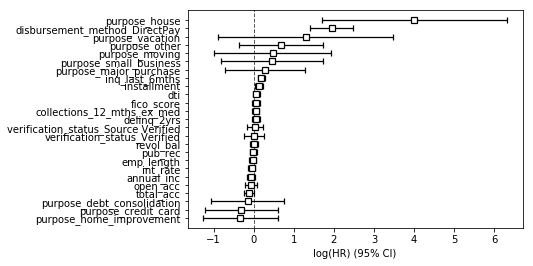

In [632]:

# Try out the Cox Proportional Hazards model
##also put this in a function.
cph = CoxPHFitter(l1_ratio=0) #we can add penalization here
cph.fit(X_train, duration_col ='mths_to_term', step_size=0.1) #fit the model

cph.print_summary() ##print regression results - need to understand some of the metrics used here
cph.plot() ##plot of coefficients and se bands

##predict on the train data. to be replaced with test data set
test_obs = (X_train.drop('mths_to_term', axis=1)).iloc[:,:]
res = pd.DataFrame(cph.predict_survival_function(test_obs, times=list(range(1,60)) )).reset_index()
res.rename(columns={'index':'time_in_months'}, inplace=True)
res = pd.DataFrame(res.mean(axis=1)).reset_index()
res.columns = ['time_in_months', 'mean_survival_probability']
res = res.set_index('time_in_months')


In [619]:
#ignore this block..manually running when testing model performance. to be replaced
#resA = res
#resB = res
#resC = res
#resD = res
#resE = res
#resF = res
#resG = res
# resA.rename(columns={'mean_survival_probability':'mean_survival_probability_A'}, inplace=True)
# resB.rename(columns={'mean_survival_probability':'mean_survival_probability_B'}, inplace=True)
# resC.rename(columns={'mean_survival_probability':'mean_survival_probability_C'}, inplace=True)
# resD.rename(columns={'mean_survival_probability':'mean_survival_probability_D'}, inplace=True)
# resE.rename(columns={'mean_survival_probability':'mean_survival_probability_E'}, inplace=True)
# resF.rename(columns={'mean_survival_probability':'mean_survival_probability_F'}, inplace=True)
# resG.rename(columns={'mean_survival_probability':'mean_survival_probability_G'}, inplace=True)

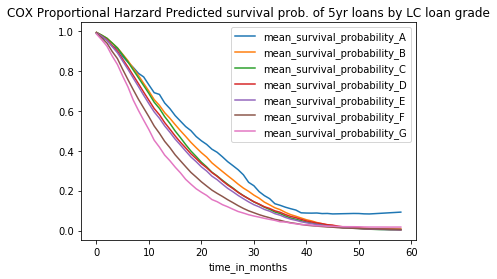

In [633]:
##merge and plot

merged_df = pd.concat([resA, resB, resC, resD, resE, resF, resG], axis=1)
merged_df.plot(title="COX Proportional Harzard Predicted survival prob. of 5yr loans by LC loan grade")

